In [1]:
# Cell 1 — Imports & global config 

import os
import math
import random
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from skimage.segmentation import slic
from skimage.measure import label as sk_label, regionprops
from skimage.morphology import (
    binary_opening,
    binary_closing,
    remove_small_holes,
    disk,
    remove_small_objects,
)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from xgboost import XGBClassifier

import joblib

# ---- Reproducibility ----
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# ---- Fixed resize scale (very important to keep consistent!) ----
FIXED_SCALE = 0.80

# ---- PATHS: CHANGE TO YOUR DATA FOLDER ----
DATA_ROOT = r"C:\BPA\data"

CLASS_MAP = {
    "Gunshot": "gunshot",
    "Impact": "impact",
}

# ---- OUTPUT DIRS ----
# Models / logs
OUTPUT_DIR = r"C:\BPA\model_expert"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Coated-feature CSV will live under FinalAE
FEATURE_OUTPUT_DIR = r"C:\BPA\FINALAE"
os.makedirs(FEATURE_OUTPUT_DIR, exist_ok=True)

# File paths
FEATURE_CSV = os.path.join(FEATURE_OUTPUT_DIR, "features_coated.csv")
MODEL_BUNDLE_PATH = os.path.join(OUTPUT_DIR, "model_bundle_expert.pkl")

print(f"  DATA_ROOT        = {DATA_ROOT}")
print(f"  OUTPUT_DIR       = {OUTPUT_DIR}")
print(f"  FEATURE_OUTPUT   = {FEATURE_OUTPUT_DIR}")
print(f"  FEATURE_CSV      = {FEATURE_CSV}")
print(f"  MODEL_BUNDLE_PATH= {MODEL_BUNDLE_PATH}")
print(f"  FIXED_SCALE      = {FIXED_SCALE}")


  DATA_ROOT        = C:\BPA\data
  OUTPUT_DIR       = C:\BPA\model_expert
  FEATURE_OUTPUT   = C:\BPA\FINALAE
  FEATURE_CSV      = C:\BPA\FINALAE\features_coated.csv
  MODEL_BUNDLE_PATH= C:\BPA\model_expert\model_bundle_expert.pkl
  FIXED_SCALE      = 0.8


In [3]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None 

MAX_SIDE = 10000
MAX_PIX  = 70_000_000

def load_image_bgr(path: str) -> np.ndarray:
    """Load image as BGR, with robust fallbacks."""
    img = None
    try:
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    except cv2.error as e:
        print(f" OpenCV error on {path}: {e}")
        img = None

    if img is not None:
        # PNG with alpha
        if len(img.shape) == 3 and img.shape[2] == 4:
            alpha = img[:, :, 3] / 255.0
            rgb = img[:, :, :3].astype(np.float32)

            rgb = np.where(
                alpha[..., None] > 0,
                rgb / np.maximum(alpha[..., None], 1e-5),
                rgb,
            )

            rgb = np.clip(rgb, 0, 255).astype(np.uint8)
            img_bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
            return img_bgr

        return img

    # Fallback to PIL
    print(f" OpenCV could not load {path}. Using PIL")
    try:
        pil_img = Image.open(path)
    except Exception as e:
        print(f"PIL also failed to open {path}: {e}")
        return None

    if pil_img.mode in ("RGBA", "LA"):
        pil_img = pil_img.convert("RGBA")
    else:
        pil_img = pil_img.convert("RGB")

    w, h = pil_img.size

    MAX_ORIG_SIDE = 25000
    MAX_ORIG_PIX  = 120_000_000

    if (w * h > MAX_ORIG_PIX) or (max(w, h) > MAX_ORIG_SIDE):
        factor_pix  = math.sqrt(MAX_ORIG_PIX / float(w * h))
        factor_side = MAX_ORIG_SIDE / float(max(w, h))
        factor = min(factor_pix, factor_side, 1.0)

        new_w = max(1, int(round(w * factor)))
        new_h = max(1, int(round(h * factor)))
        print(f"[WARN] PIL downscaling huge image at load time: {w}x{h} -> {new_w}x{new_h}")
        pil_img = pil_img.resize((new_w, new_h), Image.BILINEAR)
        w, h = new_w, new_h

    arr = np.array(pil_img)

    if arr.ndim == 3 and arr.shape[2] == 4:
        rgb = arr[:, :, :3].astype(np.uint8)
        bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    elif arr.ndim == 3 and arr.shape[2] == 3:
        bgr = cv2.cvtColor(arr.astype(np.uint8), cv2.COLOR_RGB2BGR)
    else:
        gray = arr.astype(np.uint8)
        bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    return bgr


def resize_fixed_scale(img: np.ndarray, base_scale: float = FIXED_SCALE) -> Tuple[np.ndarray, float]:
    """
    Resize image by base scale (0.80) AND apply an adaptive downscale
    only if the scaled image is still too large.
    Returns: resized_img, final_scale
    """
    h, w = img.shape[:2]
    if h == 0 or w == 0:
        raise ValueError("resize_fixed_scale: empty image.")

    scale = base_scale
    new_h = int(round(h * scale))
    new_w = int(round(w * scale))

    if (new_h * new_w > MAX_PIX) or (max(new_h, new_w) > MAX_SIDE):
        factor_pix  = math.sqrt(MAX_PIX / float(new_h * new_w))
        factor_side = MAX_SIDE / float(max(new_h, new_w))
        extra = min(factor_pix, factor_side, 1.0)

        scale *= extra
        new_h = max(1, int(round(h * scale)))
        new_w = max(1, int(round(w * scale)))

        print(" Image too large after base scale -> extra downscale applied.")
        print(f" final scale = {scale:.4f}, final size = {new_w} x {new_h}")

    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    return resized, scale

print("Image loader and resize helper ready.")


Image loader and resize helper ready.


SEGMENTATION HSV + RED DOMINANCE + COATING MASK

In [ ]:
from skimage.morphology import remove_small_objects, binary_opening, disk

def _segment_blood_binary(img_bgr_resized: np.ndarray) -> np.ndarray:
    """
    Internal helper: returns a boolean mask of blood pixels.
    This mask is NOT used directly as a feature – only to build highlight/coated images.
    """
    if img_bgr_resized is None or img_bgr_resized.size == 0:
        raise ValueError("_segment_blood_binary: empty image")

    # RGB red dominance
    b, g, r = cv2.split(img_bgr_resized)
    r_i = r.astype(np.int32)
    g_i = g.astype(np.int32)
    b_i = b.astype(np.int32)

    red_dom = (
        (r_i > g_i + 10) &
        (r_i > b_i + 10) &
        (r >= 40)
    )

    # HSV red bands
    hsv = cv2.cvtColor(img_bgr_resized, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lower1 = np.array([0,   15,  15], dtype=np.uint8)
    upper1 = np.array([12, 255, 255], dtype=np.uint8)
    lower2 = np.array([160, 15,  15], dtype=np.uint8)
    upper2 = np.array([179, 255, 255], dtype=np.uint8)

    mask_red1 = cv2.inRange(hsv, lower1, upper1)
    mask_red2 = cv2.inRange(hsv, lower2, upper2)
    base_hsv  = (mask_red1 > 0) | (mask_red2 > 0)

    base_mask = base_hsv & red_dom & (v >= 30)

    if not base_mask.any():
        return np.zeros(img_bgr_resized.shape[:2], dtype=bool)

    cleaned = remove_small_objects(base_mask, min_size=3)
    cleaned = binary_opening(cleaned, disk(1))

    if not cleaned.any():
        cleaned = base_mask

    return cleaned.astype(bool)


def make_highlight_and_coated(img_bgr_resized: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    From a resized image:
      - segment blood
      - build highlight (white background + original colour)
      - build coated grayscale mask (0 background, grayscale intensity for blood)

    Returns: highlight_bgr, coated_gray
    """
    mask_bool = _segment_blood_binary(img_bgr_resized)

    # highlight image
    highlight = np.full_like(img_bgr_resized, 255, dtype=np.uint8)
    highlight[mask_bool] = img_bgr_resized[mask_bool]

    # coated grayscale mask
    gray = cv2.cvtColor(img_bgr_resized, cv2.COLOR_BGR2GRAY)
    coated_gray = np.zeros_like(gray, dtype=np.uint8)
    coated_gray[mask_bool] = gray[mask_bool]

    return highlight, coated_gray

# Softer / more permissive binary segmentation for contingency
from skimage.morphology import remove_small_objects, binary_opening, binary_closing, disk

def _segment_blood_binary_contingency(img_bgr_resized: np.ndarray) -> np.ndarray:
    """
    Softer segmentation for contingency:
      - looser red dominance
      - allows darker stains
      - slightly more morphological cleanup/fill
    Returns a boolean mask
    """
    if img_bgr_resized is None or img_bgr_resized.size == 0:
        raise ValueError("_segment_blood_binary_contingency: empty image")

    b, g, r = cv2.split(img_bgr_resized)
    r_i = r.astype(np.int32)
    g_i = g.astype(np.int32)
    b_i = b.astype(np.int32)

    # softer red dominance, accepts weaker reds
    red_dom = (
        (r_i > g_i + 5) &
        (r_i > b_i + 5) &
        (r >= 25)           # allow darker
    )

    hsv = cv2.cvtColor(img_bgr_resized, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    # slightly wider HSV bands + lower S/V thresholds
    lower1 = np.array([0,   10,  10], dtype=np.uint8)
    upper1 = np.array([15, 255, 255], dtype=np.uint8)
    lower2 = np.array([160, 10,  10], dtype=np.uint8)
    upper2 = np.array([179, 255, 255], dtype=np.uint8)

    mask_red1 = cv2.inRange(hsv, lower1, upper1)
    mask_red2 = cv2.inRange(hsv, lower2, upper2)
    base_hsv  = (mask_red1 > 0) | (mask_red2 > 0)

    base_mask = base_hsv & red_dom & (v >= 15)

    if not base_mask.any():
        return np.zeros(img_bgr_resized.shape[:2], dtype=bool)

    # allow smaller specks, then lightly close to fill gaps
    cleaned = remove_small_objects(base_mask, min_size=2)
    cleaned = binary_opening(cleaned, disk(1))
    cleaned = binary_closing(cleaned, disk(1))

    if not cleaned.any():
        cleaned = base_mask

    return cleaned.astype(bool)


def make_highlight_and_coated_contingency(img_bgr_resized: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Contingency version:
      - uses softer segmentation (_segment_blood_binary_contingency)
      - returns highlight + coated grayscale mask
    """
    mask_bool = _segment_blood_binary_contingency(img_bgr_resized)

    # highlight image (white background)
    highlight = np.full_like(img_bgr_resized, 255, dtype=np.uint8)
    highlight[mask_bool] = img_bgr_resized[mask_bool]

    # coated grayscale mask
    gray = cv2.cvtColor(img_bgr_resized, cv2.COLOR_BGR2GRAY)
    coat = np.zeros_like(gray, dtype=np.uint8)
    coat[mask_bool] = gray[mask_bool]

    return highlight, coat



FEATURE EXTRACTION

In [6]:
# Cell 4 — Expert feature extractor (COATED ONLY: size, spread, intensity, clustering)

from typing import Dict, Tuple
from skimage.measure import label as sk_label, regionprops

def extract_expert_features_coated(coated_gray: np.ndarray,
                                   img_shape: Tuple[int, int]) -> Dict[str, float]:
    """
    Expert-inspired features using ONLY the coated grayscale mask:
      - background = 0
      - blood pixels = 1..255 (intensity from original highlight)
    """
    H, W = img_shape[:2]
    if coated_gray is None or coated_gray.size == 0:
        raise ValueError("extract_expert_features_coated: empty coated mask")

    blood_mask = coated_gray > 0
    blood_pixels = int(blood_mask.sum())
    total_pixels = int(H * W)

    feats: Dict[str, float] = {}

    # --- basic coverage ---
    feats["blood_pixels"] = float(blood_pixels)
    feats["blood_coverage"] = float(blood_pixels / total_pixels) if total_pixels > 0 else 0.0

    # template for zeros if no blood
    empty_common = {
        "total_stains": 0.0,
        "stains_per_Mpx": 0.0,
        "mean_area": 0.0,
        "median_area": 0.0,
        "std_area": 0.0,
        "max_area": 0.0,
        "dominant_ratio": 0.0,
        "top3_ratio": 0.0,
        "frac_small": 0.0,
        "frac_large": 0.0,
        "num_passive_like": 0.0,
        "frac_passive_like": 0.0,
        "dist_mean_norm": 0.0,
        "dist_std_norm": 0.0,
        "outer_pixel_frac": 0.0,
        "outer_inner_density_ratio": 0.0,
        "mean_aspect_small": 0.0,
        "mean_aspect_large": 0.0,
        "frac_elongated_small": 0.0,
        "frac_elongated_all": 0.0,
        "nn_mean_norm": 0.0,
        "nn_std_norm": 0.0,
        # intensity / mist / core / radial
        "int_mean": 0.0,
        "int_std": 0.0,
        "int_min": 0.0,
        "int_max": 0.0,
        "int_median": 0.0,
        "int_p10": 0.0,
        "int_p90": 0.0,
        "int_cv": 0.0,
        "int_entropy": 0.0,
        "mist_frac_pixels": 0.0,
        "dark_core_frac_pixels": 0.0,
        "dist_mean_intw": 0.0,
        "dist_std_intw": 0.0,
        "r50_norm": 0.0,
        "r90_norm": 0.0,
        "radial_density_slope": 0.0,
        "elong_orientation_std_deg": 0.0,
        "elong_outer_frac": 0.0,
    }

    if blood_pixels == 0:
        feats.update(empty_common)
        return feats

    # ---------- INTENSITY STATS ----------
    vals = coated_gray[blood_mask].astype(np.float32)
    int_mean = float(vals.mean())
    int_std  = float(vals.std())
    int_min  = float(vals.min())
    int_max  = float(vals.max())
    int_med  = float(np.median(vals))
    p10      = float(np.percentile(vals, 10))
    p30      = float(np.percentile(vals, 30))
    p70      = float(np.percentile(vals, 70))
    p90      = float(np.percentile(vals, 90))
    cv       = float(int_std / (int_mean + 1e-6))

    hist, _ = np.histogram(vals, bins=32, range=(0, 255), density=True)
    hist_nz = hist[hist > 0]
    entropy = float(-np.sum(hist_nz * np.log2(hist_nz)))

    feats["int_mean"]    = int_mean
    feats["int_std"]     = int_std
    feats["int_min"]     = int_min
    feats["int_max"]     = int_max
    feats["int_median"]  = int_med
    feats["int_p10"]     = p10
    feats["int_p90"]     = p90
    feats["int_cv"]      = cv
    feats["int_entropy"] = entropy

    feats["mist_frac_pixels"]      = float((vals <= p30).sum() / vals.size)
    feats["dark_core_frac_pixels"] = float((vals >= p70).sum() / vals.size)

    # ---------- REGION PROPS ----------
    labels = sk_label(blood_mask)
    regions = regionprops(labels)
    stains = [r for r in regions if r.area >= 5]
    total_stains = len(stains)
    feats["total_stains"] = float(total_stains)

    if total_stains == 0:
        feats.update(empty_common)
        return feats

    areas = np.array([r.area for r in stains], dtype=float)
    perims = np.array([r.perimeter if r.perimeter > 0 else np.nan for r in stains], dtype=float)
    major_axes = np.array([getattr(r, "major_axis_length", 0.0) for r in stains], dtype=float)
    minor_axes = np.array([getattr(r, "minor_axis_length", 0.0) for r in stains], dtype=float)

    total_blood_area = float(areas.sum())
    max_area = float(areas.max())
    feats["mean_area"] = float(areas.mean())
    feats["median_area"] = float(np.median(areas))
    feats["std_area"] = float(areas.std())
    feats["max_area"] = max_area

    feats["stains_per_Mpx"] = float(total_stains / (total_pixels / 1e6))
    feats["dominant_ratio"] = float(max_area / total_blood_area) if total_blood_area > 0 else 0.0

    sorted_areas = np.sort(areas)[::-1]
    top3 = sorted_areas[:3].sum()
    feats["top3_ratio"] = float(top3 / total_blood_area) if total_blood_area > 0 else 0.0

    q1 = float(np.percentile(areas, 25))
    q3 = float(np.percentile(areas, 75))
    frac_small = float((areas <= q1).sum() / total_stains)
    frac_large = float((areas >= q3).sum() / total_stains)
    feats["frac_small"] = frac_small
    feats["frac_large"] = frac_large

    # passive-like
    num_passive_like = 0
    for a, maj, min_ax, per in zip(areas, major_axes, minor_axes, perims):
        if a < feats["median_area"]:
            continue
        if maj <= 0 or min_ax <= 0 or math.isnan(per) or per <= 0:
            continue
        aspect_ratio = min_ax / maj
        circularity = 4.0 * math.pi * a / (per * per)
        if aspect_ratio >= 0.8 and circularity >= 0.7:
            num_passive_like += 1
    feats["num_passive_like"] = float(num_passive_like)
    feats["frac_passive_like"] = float(num_passive_like / total_stains)

    # ---------- SPATIAL SPREAD & RADIAL ----------
    ys, xs = np.nonzero(blood_mask)
    cy, cx = ys.mean(), xs.mean()
    dists = np.sqrt((ys - cy) ** 2 + (xs - cx) ** 2)
    diag = math.sqrt(H * H + W * W)
    d_norm = dists / diag

    feats["dist_mean_norm"] = float(d_norm.mean())
    feats["dist_std_norm"] = float(d_norm.std())

    # intensity-weighted radius
    w = vals / 255.0
    wsum = float(w.sum()) + 1e-6
    mean_intw = float((d_norm * w).sum() / wsum)
    var_intw = float(((d_norm - mean_intw) ** 2 * w).sum() / wsum)
    feats["dist_mean_intw"] = mean_intw
    feats["dist_std_intw"] = math.sqrt(max(var_intw, 0.0))

    feats["r50_norm"] = float(np.quantile(d_norm, 0.5))
    feats["r90_norm"] = float(np.quantile(d_norm, 0.9))

    # radial density slope (log density vs radius)
    n_bins = 8
    r_bins = np.linspace(0.0, d_norm.max() + 1e-6, n_bins + 1)
    counts, _ = np.histogram(d_norm, bins=r_bins)
    r_mid = 0.5 * (r_bins[:-1] + r_bins[1:])
    areas_ann = (r_bins[1:]**2 - r_bins[:-1]**2) * math.pi
    dens = counts / (areas_ann + 1e-6)
    valid = dens > 0
    if valid.sum() >= 2:
        logd = np.log(dens[valid])
        slope, _ = np.polyfit(r_mid[valid], logd, 1)
        feats["radial_density_slope"] = float(slope)
    else:
        feats["radial_density_slope"] = 0.0

    core_r = 0.08
    outer_r = 0.35
    core_mask = d_norm <= core_r
    outer_mask = (d_norm > core_r) & (d_norm <= outer_r)
    total_pix = float(len(d_norm))
    core_pix = float(core_mask.sum())
    outer_pix = float(outer_mask.sum())
    feats["outer_pixel_frac"] = float(outer_pix / total_pix) if total_pix > 0 else 0.0

    core_area = math.pi * (core_r * diag) ** 2
    ring_area = math.pi * (outer_r * diag) ** 2 - core_area
    if core_area <= 0 or ring_area <= 0:
        feats["outer_inner_density_ratio"] = 0.0
    else:
        core_density = core_pix / core_area
        outer_density = outer_pix / ring_area
        feats["outer_inner_density_ratio"] = float(
            outer_density / core_density if core_density > 0 else 0.0
        )

    # ---------- MICROTEXTURE & ORIENTATION ----------
    aspects = np.zeros_like(areas, dtype=float)
    for i, (maj, min_ax) in enumerate(zip(major_axes, minor_axes)):
        aspects[i] = (min_ax / maj) if maj > 0 else 0.0

    elongated_mask = aspects <= 0.6
    small_mask = areas <= q1
    large_mask = areas >= q3

    feats["mean_aspect_small"] = float(aspects[small_mask].mean()) if small_mask.any() else 0.0
    feats["mean_aspect_large"] = float(aspects[large_mask].mean()) if large_mask.any() else 0.0

    if small_mask.any():
        feats["frac_elongated_small"] = float((elongated_mask & small_mask).sum() / small_mask.sum())
    else:
        feats["frac_elongated_small"] = 0.0
    feats["frac_elongated_all"] = float(elongated_mask.sum() / float(total_stains))

    elong_regions = [r for r, el in zip(stains, elongated_mask) if el]
    if len(elong_regions) > 0:
        ori = np.array([reg.orientation for reg in elong_regions], dtype=float)
        ori_deg = np.rad2deg(ori)
        feats["elong_orientation_std_deg"] = float(abs(ori_deg).std())
    else:
        feats["elong_orientation_std_deg"] = 0.0

    # elongations in outer region
    coords = np.array([r.centroid for r in stains], dtype=float)
    cy_s, cx_s = coords.mean(axis=0)
    d_stain = np.sqrt((coords[:, 0] - cy_s) ** 2 + (coords[:, 1] - cx_s) ** 2)
    d_stain_norm = d_stain / diag
    outer_stain_mask = d_stain_norm > 0.15
    if outer_stain_mask.any():
        feats["elong_outer_frac"] = float((elongated_mask & outer_stain_mask).sum()
                                          / outer_stain_mask.sum())
    else:
        feats["elong_outer_frac"] = 0.0

    # ---------- CLUSTERING (NN) ----------
    total_stains = len(stains)
    if total_stains > 1:
        MAX_NN_POINTS = 4000
        if total_stains <= MAX_NN_POINTS:
            coords_use = coords
        else:
            rng = np.random.default_rng(RANDOM_SEED)
            idx = rng.choice(total_stains, size=MAX_NN_POINTS, replace=False)
            coords_use = coords[idx]

        diff = coords_use[:, None, :] - coords_use[None, :, :]
        dist_mat = np.sqrt((diff ** 2).sum(axis=2))
        np.fill_diagonal(dist_mat, np.inf)
        nn = dist_mat.min(axis=1)
        nn_norm = nn / diag
        feats["nn_mean_norm"] = float(nn_norm.mean())
        feats["nn_std_norm"] = float(nn_norm.std())
    else:
        feats["nn_mean_norm"] = 0.0
        feats["nn_std_norm"] = 0.0

    return feats

print("Coated-only expert feature extractor ready.")


Coated-only expert feature extractor ready.


FOR GETTING THE INTENSITY BELOW THE COATING 

In [7]:
def add_color_features_from_coated(feat_dict: Dict[str, float],
                                   coated_gray: np.ndarray,
                                   img_bgr: np.ndarray) -> None:
    """
    Add mean RGB/HSV and red-dominance under the coated blood region.
    """
    blood_mask = coated_gray > 0
    if not blood_mask.any():
        feat_dict["mean_R"] = 0.0
        feat_dict["mean_G"] = 0.0
        feat_dict["mean_B"] = 0.0
        feat_dict["mean_S"] = 0.0
        feat_dict["mean_V"] = 0.0
        feat_dict["mean_Rdom"] = 0.0
        return

    b_ch, g_ch, r_ch = cv2.split(img_bgr)
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    h_ch, s_ch, v_ch = cv2.split(hsv)

    feat_dict["mean_R"] = float(r_ch[blood_mask].mean())
    feat_dict["mean_G"] = float(g_ch[blood_mask].mean())
    feat_dict["mean_B"] = float(b_ch[blood_mask].mean())
    feat_dict["mean_S"] = float(s_ch[blood_mask].mean())
    feat_dict["mean_V"] = float(v_ch[blood_mask].mean())
    feat_dict["mean_Rdom"] = float(
        (r_ch[blood_mask] - 0.5 * (g_ch[blood_mask] + b_ch[blood_mask])).mean()
    )


SAMPLE TEST FOR SEGMENTATIOMN TESTING AND FEATURE EXTRACTION (I KNOW IT WILL WORK SO ITS FOR OTHERS NOT ME )

[TEST] Extracted coated-only features for test image:
  Path: C:\BPA\G2.png


,blood_pixels,blood_coverage,int_mean,int_std,int_min,int_max,int_median,int_p10,int_p90,int_cv,...,elong_orientation_std_deg,elong_outer_frac,nn_mean_norm,nn_std_norm,mean_R,mean_G,mean_B,mean_S,mean_V,mean_Rdom
0,11097.0,0.016544,91.467697,26.89847,19.0,160.0,94.0,53.0,126.0,0.294076,...,24.700233,0.0,0.009214,0.008809,115.585564,83.512301,69.235109,109.186807,115.585564,41.991709


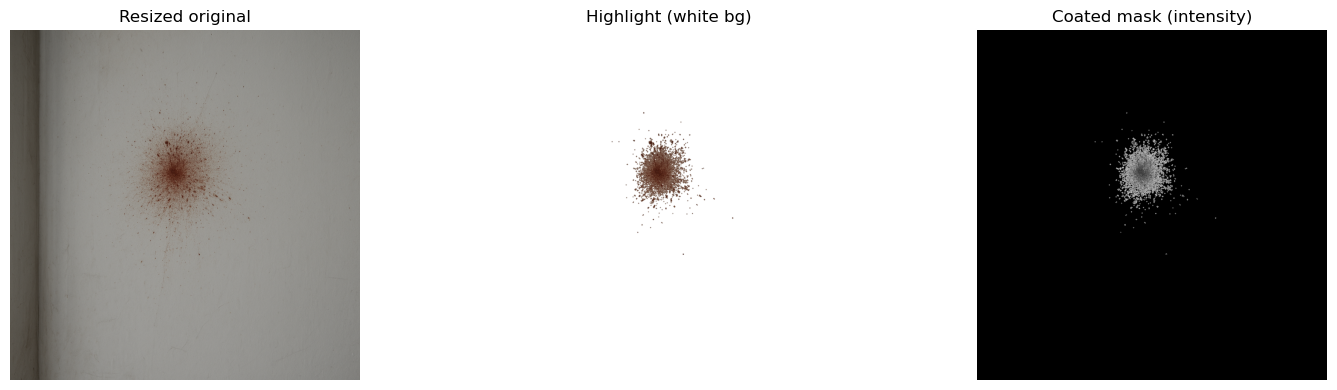

In [7]:
# Cell Test -B — Feature table for the same test image (COATED ONLY)

# Choose a test image
TEST_IMAGE_FEAT = r"C:\BPA\G2.png"   # <-- change as needed

# Load + resize
img_test = load_image_bgr(TEST_IMAGE_FEAT)
if img_test is None:
    raise ValueError(f"Could not read test image: {TEST_IMAGE_FEAT}")

img_resized_test, _ = resize_fixed_scale(img_test, FIXED_SCALE)
H2, W2 = img_resized_test.shape[:2]


# Highlight + Coated mask (the only mask we use now)
highlight_test, coat_mask_test = make_highlight_and_coated(img_resized_test)


# Extract coated-only expert features

feats_test = extract_expert_features_coated(coat_mask_test, img_shape=(H2, W2))

# Colour features (RGB/HSV averages)
add_color_features_from_coated(feats_test, coat_mask_test, img_resized_test)

# Display feature row
df_test_feats = pd.DataFrame([feats_test])
print("[TEST] Extracted coated-only features for test image:")
print(f"  Path: {TEST_IMAGE_FEAT}")
display(df_test_feats)

# 6) Visualization 
img_rgb  = cv2.cvtColor(img_resized_test,  cv2.COLOR_BGR2RGB)
hl_rgb   = cv2.cvtColor(highlight_test,    cv2.COLOR_BGR2RGB)
coat_show = coat_mask_test

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title("Resized original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(hl_rgb)
plt.title("Highlight (white bg)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(coat_show, cmap="gray")
plt.title("Coated mask (intensity)")
plt.axis("off")

plt.tight_layout()
plt.show()


GENERATING DATASET FOR MODEL TRAINING 

In [9]:
# Cell 5 — Build COATED feature dataset with detailed per-image logs + hard reset

def build_expert_dataset(data_root: str, class_map: Dict[str, str]) -> pd.DataFrame:
    rows: List[Dict[str, float]] = []   # accumulates ALL images (never reset)
    skipped: List[str] = []

    root_path = Path(data_root)
    if not root_path.exists():
        raise ValueError(f"DATA_ROOT does not exist: {data_root}")

    # Ensure output dir exists and old CSV does not cause confusion
    out_dir = Path(os.path.dirname(FEATURE_CSV))
    out_dir.mkdir(parents=True, exist_ok=True)
    if os.path.exists(FEATURE_CSV):
        print(f"[INFO] Removing existing feature file: {FEATURE_CSV}")
        os.remove(FEATURE_CSV)

    for folder_name, label in class_map.items():
        folder_path = root_path / folder_name
        if not folder_path.exists():
            print(f"[WARN] Folder missing: {folder_path}")
            continue

        img_files = [
            f for f in os.listdir(folder_path)
            if f.lower().endswith((".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp"))
        ]
        img_files.sort()
        total_imgs = len(img_files)

        print(f"\n[INFO] Folder '{folder_name}' ({label}) → {total_imgs} images")

        for idx, fname in enumerate(img_files, start=1):
            print(f"\n Processing {fname}  ({idx}/{total_imgs}) ")

            img_path = str(folder_path / fname)

            # ---- HARD RESET PER IMAGE (only temporaries) ----
            img_resized = None
            highlight = None
            coat = None

            # ---- LOAD IMAGE ----
            img = load_image_bgr(img_path)
            if img is None:
                print(f" Could not read even with fallback: {fname}")
                skipped.append(img_path)
                continue

            orig_h, orig_w = img.shape[:2]

            # ---- RESIZE ----
            img_resized, final_scale = resize_fixed_scale(img, FIXED_SCALE)
            new_h, new_w = img_resized.shape[:2]
            print(f" Resized size : {new_w} x {new_h}")
            print(f" Final scale used: {final_scale:.4f}")

            # ---- SEGMENT + BUILD HIGHLIGHT & COATED MASK ----
            # This uses your _segment_blood_binary internally
            highlight, coat = make_highlight_and_coated(img_resized)

            # ---- FEATURE EXTRACTION FROM COATED MASK ----
            feats: Dict[str, float] = extract_expert_features_coated(
                coat, img_shape=(new_h, new_w)
            )
            add_color_features_from_coated(feats, coat, img_resized)

            # ---- META ----
            feats["path"] = img_path
            feats["label"] = label

            # Append THIS image's features; rows is never reset
            rows.append(feats)
            print(" Features extracted and stored")

        print(f" Finished folder: {folder_name}")

    if not rows:
        raise RuntimeError("No images processed. Check DATA_ROOT and CLASS_MAP.")

    # Build dataframe and SAVE (overwrite) to CSV
    df = pd.DataFrame(rows)
    df.to_csv(FEATURE_CSV, index=False)
    print(f"\n Dataset built successfully and saved to: {FEATURE_CSV}")
    print(f" Total rows: {len(df)}")

    # Save skipped images list if any
    if skipped:
        skipped_log = os.path.join(OUTPUT_DIR, "skipped_images.txt")
        with open(skipped_log, "w", encoding="utf-8") as f:
            for p in skipped:
                f.write(p + "\n")
        print(f" Skipped {len(skipped)} images. List saved to: {skipped_log}")
    else:
        print(" No images were skipped.")

    return df


# ----- Build dataset (fresh each time, CSV overwritten) -----
df_features = build_expert_dataset(DATA_ROOT, CLASS_MAP)



[INFO] Folder 'Gunshot' (gunshot) → 436 images

 Processing GS - 100.jpg  (1/436) 
 Resized size : 8000 x 6266
 Final scale used: 0.8000
 Features extracted and stored

 Processing GS - 101.jpg  (2/436) 
 Resized size : 8000 x 6266
 Final scale used: 0.8000
 Features extracted and stored

 Processing GS - 102.jpg  (3/436) 
 Resized size : 8000 x 6266
 Final scale used: 0.8000
 Features extracted and stored

 Processing GS - 103.jpg  (4/436) 
 Resized size : 8000 x 6266
 Final scale used: 0.8000
 Features extracted and stored

 Processing GS - 104.jpg  (5/436) 
 Resized size : 8000 x 6260
 Final scale used: 0.8000
 Features extracted and stored

 Processing GS - 105.jpg  (6/436) 
 Resized size : 8000 x 6260
 Final scale used: 0.8000
 Features extracted and stored

 Processing GS - 106.jpg  (7/436) 
 Resized size : 8000 x 6260
 Final scale used: 0.8000
 Features extracted and stored

 Processing GS - 107.jpg  (8/436) 
 Resized size : 8000 x 6260
 Final scale used: 0.8000
 Features extra

TRAINING THE MODELS AND SAVING THEM

In [23]:
from catboost.utils import get_gpu_device_count
print("Available GPUs:", get_gpu_device_count())

Available GPUs: 1


In [ ]:
# Cell 8 — Train CatBoost + Platt calibration and save bundle

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier
import joblib

#  Load feature dataset 
df_features = pd.read_csv(FEATURE_CSV)

feature_cols = [c for c in df_features.columns if c not in ("label", "path")]
X = df_features[feature_cols].values.astype(float)
y_str = df_features["label"].values

# Encode labels -> int
class_names = sorted(np.unique(y_str))           # ['gunshot', 'impact']
label_to_int = {name: i for i, name in enumerate(class_names)}
int_to_label = {i: name for name, i in label_to_int.items()}

y = np.array([label_to_int[s] for s in y_str], dtype=int)

# --- Train / Test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_SEED
)

print("Train class distribution:", Counter(y_train))
print("Test  class distribution:", Counter(y_test))

# Train CatBoost (GPU)

cat_model = CatBoostClassifier(
    iterations=2000,
    depth=8,
    learning_rate=0.02,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=RANDOM_SEED,
    task_type="GPU",             # CPU -> "CPU"
    devices="0",
    auto_class_weights="Balanced",   # gently help gunshot
    verbose=False,
)

cat_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False,
)

# Quick argmax evaluation (this is your REAL classifier)
y_pred_argmax = cat_model.predict(X_test).astype(int)
print("\n[CatBoost argmax] Classification report:")
print(classification_report(y_test, y_pred_argmax,
                            target_names=class_names))

print("[CatBoost argmax] Confusion matrix:")
print(confusion_matrix(y_test, y_pred_argmax))

# Fit Platt calibration on gunshot score

# Find numeric label for 'gunshot'
gun_label = label_to_int["gunshot"]

# Get column index in predict_proba output for gunshot
classes_num = list(cat_model.classes_)          # numeric labels in order of proba columns
gun_col_idx = classes_num.index(gun_label)

# Raw gunshot scores
scores_train = cat_model.predict_proba(X_train)[:, gun_col_idx]
scores_test  = cat_model.predict_proba(X_test)[:, gun_col_idx]

# Binary targets: 1 = gunshot, 0 = impact
y_train_bin = (y_train == gun_label).astype(int)
y_test_bin  = (y_test  == gun_label).astype(int)

# Platt scaling (logistic regression on 1D scores)
calib_lr = LogisticRegression()
calib_lr.fit(scores_train.reshape(-1, 1), y_train_bin)

# Compare AUC raw vs calibrated
auc_raw = roc_auc_score(y_test_bin, scores_test)
probs_test_cal = calib_lr.predict_proba(scores_test.reshape(-1, 1))[:, 1]
auc_cal = roc_auc_score(y_test_bin, probs_test_cal)

print(f"\n[Calibration] AUC raw: {auc_raw:.4f}, AUC calibrated: {auc_cal:.4f}")


# 3) Save bundle with CatBoost + calibrator
bundle = {
    "cat_model": cat_model,
    "calib_lr": calib_lr,
    "feature_cols": feature_cols,
    "class_names": class_names,
    "label_to_int": label_to_int,
    "int_to_label": int_to_label,
}

joblib.dump(bundle, MODEL_BUNDLE_PATH)
print(f"\nModel bundle (CatBoost + calibration) saved to:\n  {MODEL_BUNDLE_PATH}")


Train class distribution: Counter({np.int64(1): 375, np.int64(0): 349})
Test  class distribution: Counter({np.int64(1): 94, np.int64(0): 87})


Default metric period is 5 because AUC is/are not implemented for GPU



[CatBoost argmax] Classification report:
              precision    recall  f1-score   support

     gunshot       0.94      0.95      0.95        87
      impact       0.96      0.95      0.95        94

    accuracy                           0.95       181
   macro avg       0.95      0.95      0.95       181
weighted avg       0.95      0.95      0.95       181

[CatBoost argmax] Confusion matrix:
[[83  4]
 [ 5 89]]

[Calibration] AUC raw: 0.9936, AUC calibrated: 0.9936

Model bundle (CatBoost + calibration) saved to:
  C:\BPA\model_expert\model_bundle_expert.pkl


IMAGE PREDICTION

In [12]:
# Cell 9 — Single-image prediction with contingency (CatBoost + calibrated probs)

import os
from typing import Dict

bundle = joblib.load(MODEL_BUNDLE_PATH)

cat_model    = bundle["cat_model"]
calib_lr     = bundle["calib_lr"]
feature_cols = bundle["feature_cols"]
class_names  = bundle["class_names"]
label_to_int = bundle["label_to_int"]
int_to_label = bundle["int_to_label"]

# fixed order for probs: index 0 = impact, index 1 = gunshot
ORDERED_CLASSES = ["impact", "gunshot"]

# locate gunshot column in CatBoost outputs
gun_label   = label_to_int["gunshot"]
classes_num = list(cat_model.classes_)
gun_col_idx = classes_num.index(gun_label)

# contingency triggers
CONF_THRESHOLD   <= 0.70     # if max prob < this → run contingency
MIN_BLOOD_COV    = 5e-4     # very weak mask
MIN_TOTAL_STAINS = 3        # almost empty segmentation


def _calibrated_proba_single(X_row_2d: np.ndarray) -> np.ndarray:
    """
    X_row_2d: shape (1, n_features)
    Returns [P(impact), P(gunshot)] after Platt calibration.
    """
    raw_scores = cat_model.predict_proba(X_row_2d)[:, gun_col_idx]     # (1,)
    gun_cal = calib_lr.predict_proba(raw_scores.reshape(-1, 1))[:, 1]  # (1,)
    imp_cal = 1.0 - gun_cal
    return np.array([imp_cal[0], gun_cal[0]], dtype=float)


def _features_to_row(feats: Dict[str, float]) -> np.ndarray:
    """Map feature dict into a 1xN row aligned to feature_cols."""
    row = {c: 0.0 for c in feature_cols}
    for k, v in feats.items():
        if k in row:
            row[k] = float(v)
    return pd.DataFrame([row], columns=feature_cols).values.astype(float)


def predict_image_expert(img_path: str) -> Dict[str, object]:
    # ---------- 1) Load + resize ----------
    img = load_image_bgr(img_path)
    if img is None:
        raise ValueError(f"Could not read file: {img_path}")

    orig_h, orig_w = img.shape[:2]
    img_resized, final_scale = resize_fixed_scale(img, FIXED_SCALE)
    H2, W2 = img_resized.shape[:2]

    fname = os.path.basename(img_path)
    print(f"[SIZE] {fname}")
    print(f"       original: {orig_w} x {orig_h}")
    print(f"       final:    {W2} x {H2}")
    print(f"       scale:    {final_scale:.4f}\n")

    # ---------- 2) MAIN segmentation → coated mask ----------
    hl_main, coat_main = make_highlight_and_coated(img_resized)

    feats_main = extract_expert_features_coated(coat_main, img_shape=(H2, W2))
    add_color_features_from_coated(feats_main, coat_main, img_resized)

    X_row_main = _features_to_row(feats_main)
    probs_main_vec = _calibrated_proba_single(X_row_main)   # [P(impact), P(gunshot)]

    max_main = float(probs_main_vec.max())
    cls_main = ORDERED_CLASSES[int(np.argmax(probs_main_vec))]

    print(f"[MAIN] {fname} -> {cls_main}  (conf={max_main:.3f})")
    print("       Probs(main):", {c: round(float(p), 3) for c, p in zip(ORDERED_CLASSES, probs_main_vec)})

    blood_cov    = feats_main.get("blood_coverage", 0.0)
    total_stains = feats_main.get("total_stains", 0.0)

    low_conf   = max_main < CONF_THRESHOLD
    weak_mask  = blood_cov < MIN_BLOOD_COV
    few_stains = total_stains < MIN_TOTAL_STAINS

    need_contingency = low_conf or weak_mask or few_stains

    final_label = cls_main
    final_conf  = max_main
    final_probs = probs_main_vec.copy()
    final_feats = feats_main
    final_mask  = coat_main
    used_cont   = False

    # CONTINGENCY path (softer segmentation) 
    if need_contingency:
        print(" -> Triggering contingency (",
              f"low_conf={low_conf}, weak_mask={weak_mask}, few_stains={few_stains}",
              ")")

        hl_cont, coat_cont = make_highlight_and_coated_contingency(img_resized)

        feats_cont = extract_expert_features_coated(coat_cont, img_shape=(H2, W2))
        add_color_features_from_coated(feats_cont, coat_cont, img_resized)

        X_row_cont = _features_to_row(feats_cont)
        probs_cont_vec = _calibrated_proba_single(X_row_cont)

        max_cont = float(probs_cont_vec.max())
        cls_cont = ORDERED_CLASSES[int(np.argmax(probs_cont_vec))]

        print(f"[CONT] {fname} -> {cls_cont}  (conf={max_cont:.3f})")
        print("       Probs(cont):", {c: round(float(p), 3) for c, p in zip(ORDERED_CLASSES, probs_cont_vec)})

        # choose whichever is more confident
        if max_cont > max_main:
            print(" -> Using CONTINGENCY result (higher confidence).")
            used_cont   = True
            final_label = cls_cont
            final_conf  = max_cont
            final_probs = probs_cont_vec.copy()
            final_feats = feats_cont
            final_mask  = coat_cont
        else:
            print(" -> Keeping MAIN result (more confident).")
    else:
        print(" -> Main path confident; no contingency needed.")

    print(f"\n[FINAL] {fname} -> {final_label} (conf={final_conf:.3f})")

    return {
        "path": img_path,
        "pred_label": final_label,
        "confidence": final_conf,
        "probs": {c: float(p) for c, p in zip(ORDERED_CLASSES, final_probs)},
        "features": final_feats,
        "mask": final_mask,              # coated mask actually used
        "used_contingency": used_cont,
        "model_used": "catboost_calibrated_with_contingency",
    }



IMAGE TESTING - DATASET

[SIZE] GS - 114.jpg
       original: 10000 x 7804
       final:    8000 x 6243
       scale:    0.8000

[MAIN] GS - 114.jpg -> gunshot  (conf=0.949)
       Probs(main): {'impact': 0.051, 'gunshot': 0.949}
 -> Main path confident; no contingency needed.

[FINAL] GS - 114.jpg -> gunshot (conf=0.949)

Prediction summary:
  Path       : C:\BPA\data\Gunshot\GS - 114.jpg
  Label      : gunshot
  Confidence : 0.949
  Probabilities:
    impact    : 0.051
    gunshot   : 0.949


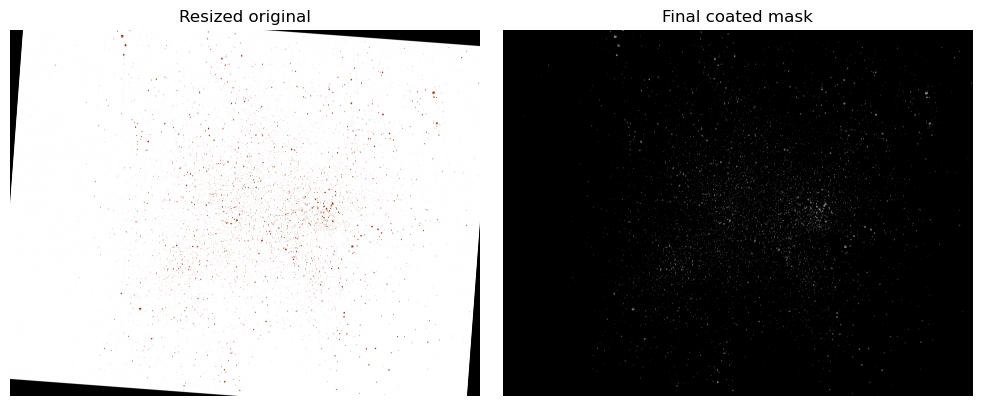

In [9]:
# quick smoke test (you can change the path)
test_path = r"C:\BPA\data\Gunshot\GS - 114.jpg"
result = predict_image_expert(test_path)

print("\nPrediction summary:")
print(f"  Path       : {result['path']}")
print(f"  Label      : {result['pred_label']}")
print(f"  Confidence : {result['confidence']:.3f}")
print("  Probabilities:")
for cls, p in result["probs"].items():
    print(f"    {cls:10s}: {p:.3f}")

# visualize original vs coated mask
img_show = load_image_bgr(test_path)
img_resized_show, _ = resize_fixed_scale(img_show, FIXED_SCALE)
img_rgb_show = cv2.cvtColor(img_resized_show, cv2.COLOR_BGR2RGB)
mask_show = result["mask"]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb_show)
plt.title("Resized original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_show, cmap="gray")
plt.title("Final coated mask")
plt.axis("off")

plt.tight_layout()
plt.show()

 Image too large after base scale -> extra downscale applied.
 final scale = 0.3788, final size = 6364 x 10000

Prediction summary:
  Path       : C:\BPA\data\Impact\C7.jpg
  Label      : impact
  Confidence : 0.929
  Probabilities:
    gunshot   : 0.071
    impact    : 0.929
 Image too large after base scale -> extra downscale applied.
 final scale = 0.3788, final size = 6364 x 10000


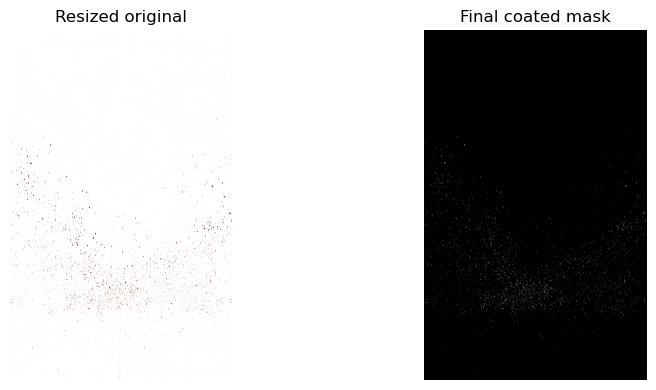

In [33]:
# quick smoke test (you can change the path)
test_path = r"C:\BPA\data\Impact\C7.jpg"
result = predict_image_expert(test_path)

print("\nPrediction summary:")
print(f"  Path       : {result['path']}")
print(f"  Label      : {result['pred_label']}")
print(f"  Confidence : {result['confidence']:.3f}")
print("  Probabilities:")
for cls, p in result["probs"].items():
    print(f"    {cls:10s}: {p:.3f}")

# visualize original vs coated mask
img_show = load_image_bgr(test_path)
img_resized_show, _ = resize_fixed_scale(img_show, FIXED_SCALE)
img_rgb_show = cv2.cvtColor(img_resized_show, cv2.COLOR_BGR2RGB)
mask_show = result["mask"]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb_show)
plt.title("Resized original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_show, cmap="gray")
plt.title("Final coated mask")
plt.axis("off")

plt.tight_layout()
plt.show()

EXTERNAL IMAGES 


AI Created Image for Gunshot spatter 

[SIZE] G2.png
       original: 1024 x 1024
       final:    819 x 819
       scale:    0.8000

[MAIN] G2.png -> gunshot  (conf=0.821)
       Probs(main): {'impact': 0.179, 'gunshot': 0.821}
 -> Main path confident; no contingency needed.

[FINAL] G2.png -> gunshot (conf=0.821)

Prediction summary:
  Path       : C:\BPA\G2.png
  Label      : gunshot
  Confidence : 0.821
  Probabilities:
    impact    : 0.179
    gunshot   : 0.821


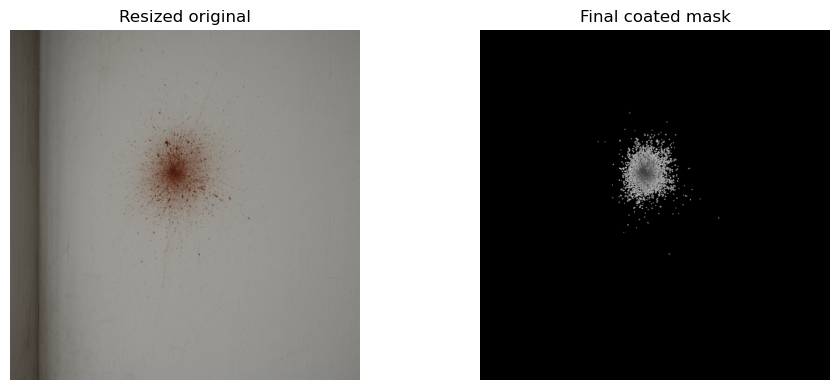

In [13]:
# quick smoke test (you can change the path)
test_path = r"C:\BPA\G2.png"
result = predict_image_expert(test_path)

print("\nPrediction summary:")
print(f"  Path       : {result['path']}")
print(f"  Label      : {result['pred_label']}")
print(f"  Confidence : {result['confidence']:.3f}")
print("  Probabilities:")
for cls, p in result["probs"].items():
    print(f"    {cls:10s}: {p:.3f}")

# visualize original vs coated mask
img_show = load_image_bgr(test_path)
img_resized_show, _ = resize_fixed_scale(img_show, FIXED_SCALE)
img_rgb_show = cv2.cvtColor(img_resized_show, cv2.COLOR_BGR2RGB)
mask_show = result["mask"]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb_show)
plt.title("Resized original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_show, cmap="gray")
plt.title("Final coated mask")
plt.axis("off")

plt.tight_layout()
plt.show()

AI created Gun spatter image using dataset as reference GS - 183

[SIZE] G.png
       original: 1024 x 1024
       final:    819 x 819
       scale:    0.8000

[MAIN] G.png -> gunshot  (conf=0.624)
       Probs(main): {'impact': 0.376, 'gunshot': 0.624}
 -> Triggering contingency ( low_conf=True, weak_mask=False, few_stains=False )
[CONT] G.png -> impact  (conf=0.561)
       Probs(cont): {'impact': 0.561, 'gunshot': 0.439}
 -> Keeping MAIN result (more confident).

[FINAL] G.png -> gunshot (conf=0.624)

Prediction summary:
  Path       : C:\BPA\G.png
  Label      : gunshot
  Confidence : 0.624
  Probabilities:
    impact    : 0.376
    gunshot   : 0.624


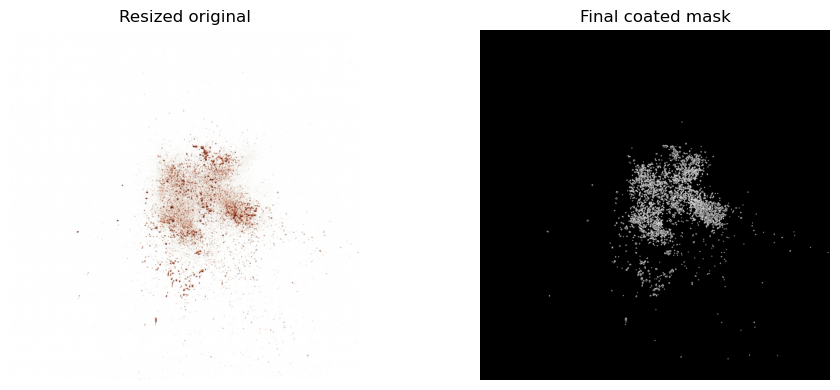

In [14]:
# quick smoke test (you can change the path)
test_path = r"C:\BPA\G.png"
result = predict_image_expert(test_path)

print("\nPrediction summary:")
print(f"  Path       : {result['path']}")
print(f"  Label      : {result['pred_label']}")
print(f"  Confidence : {result['confidence']:.3f}")
print("  Probabilities:")
for cls, p in result["probs"].items():
    print(f"    {cls:10s}: {p:.3f}")

# visualize original vs coated mask
img_show = load_image_bgr(test_path)
img_resized_show, _ = resize_fixed_scale(img_show, FIXED_SCALE)
img_rgb_show = cv2.cvtColor(img_resized_show, cv2.COLOR_BGR2RGB)
mask_show = result["mask"]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb_show)
plt.title("Resized original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_show, cmap="gray")
plt.title("Final coated mask")
plt.axis("off")

plt.tight_layout()
plt.show()

Prediction summary:
 Label      : impact
 Confidence : 0.973
 Model used : cat
 Probabilities:
   gunshot   : 0.027
   impact    : 0.973


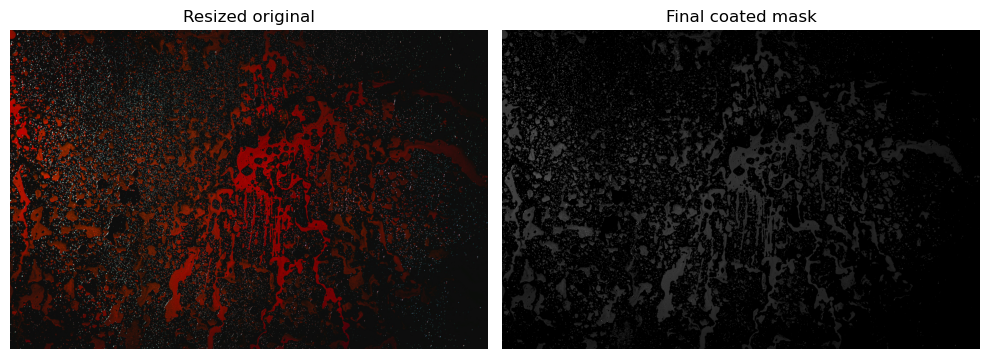

In [31]:
# quick smoke test
test_path = r"C:\BPA\impavt(b).jpg"
result = predict_image_expert(test_path)

print("Prediction summary:")
print(" Label      :", result["pred_label"])
print(" Confidence :", f"{result['confidence']:.3f}")
print(" Model used :", result["model_used"])
print(" Probabilities:")
for k, v in result["probs"].items():
    print(f"   {k:10s}: {v:.3f}")


img_show = load_image_bgr(test_path)
img_resized_show, _ = resize_fixed_scale(img_show, FIXED_SCALE)
img_rgb_show = cv2.cvtColor(img_resized_show, cv2.COLOR_BGR2RGB)
mask_show = result["mask"]   # coated

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb_show)
plt.title("Resized original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_show, cmap="gray")
plt.title("Final coated mask")
plt.axis("off")

plt.tight_layout()
plt.show()


EVALUATION 

=== Classification report (argmax decision) ===
              precision    recall  f1-score   support

     gunshot       0.94      0.95      0.95        87
      impact       0.96      0.95      0.95        94

    accuracy                           0.95       181
   macro avg       0.95      0.95      0.95       181
weighted avg       0.95      0.95      0.95       181

Confusion matrix (argmax):
[[83  4]
 [ 5 89]]


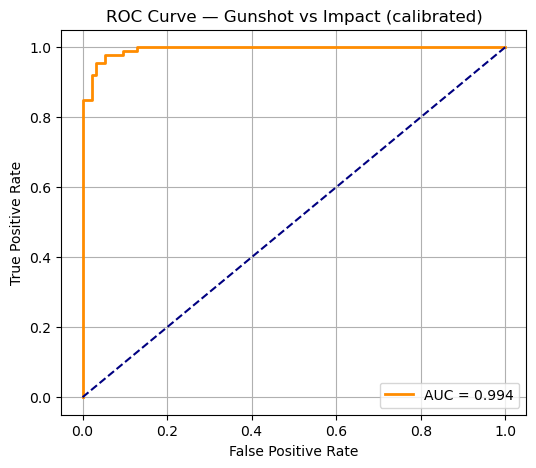

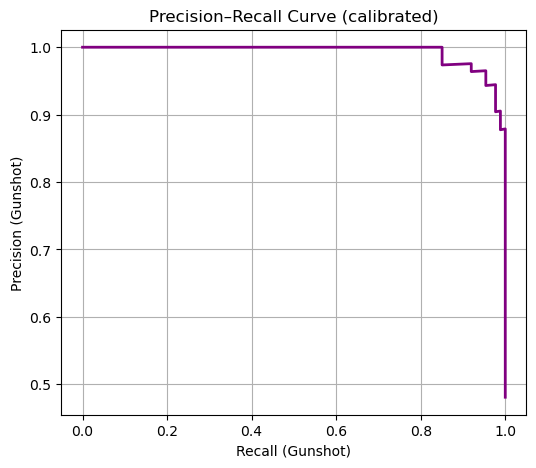


Best F1 Threshold (calibrated P(gunshot)): 0.100  |  F1 = 0.960


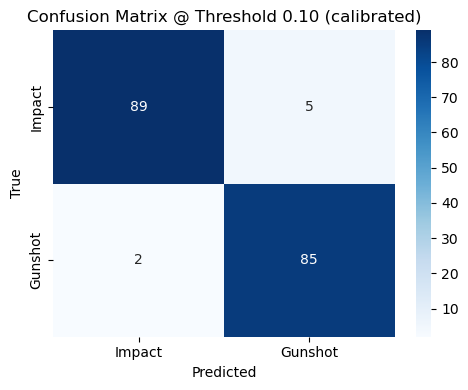

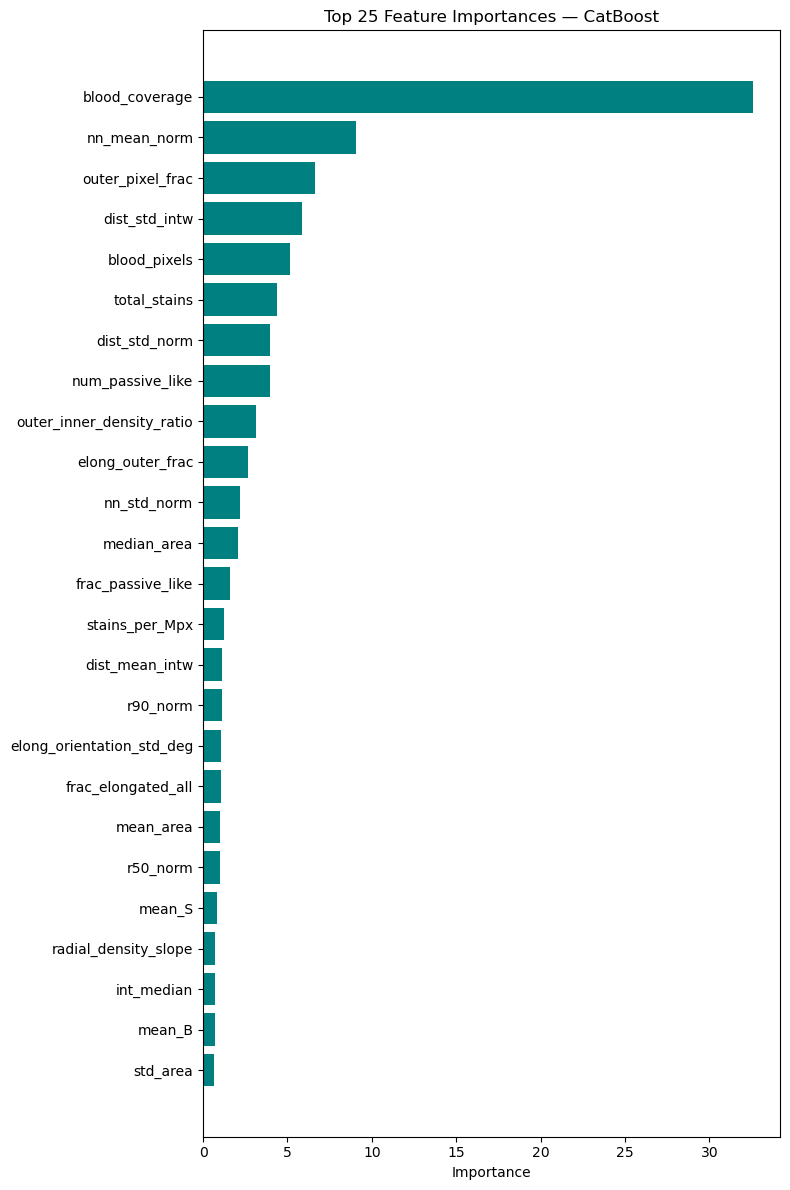

In [34]:
# Cell X — Final Diagnostics: ROC, PR, Argmax Report, Best Threshold CM, Feature Importances



# Load model bundle + feature dataset

bundle = joblib.load(MODEL_BUNDLE_PATH)

cat_model    = bundle["cat_model"]      # CatBoost model
calib_lr     = bundle["calib_lr"]       # Platt calibration (LogisticRegression)
feature_cols = bundle["feature_cols"]
label_to_int = bundle["label_to_int"]
int_to_label = bundle["int_to_label"]

df = pd.read_csv(FEATURE_CSV)
X = df[feature_cols].values.astype(float)
y_str = df["label"].values
y = np.array([label_to_int[s] for s in y_str], dtype=int)

# Same split as training
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_SEED
)

# Numeric label for gunshot (positive class)
gun_label = label_to_int["gunshot"]

# Column index for gunshot in cat_model.predict_proba output
classes_num = list(cat_model.classes_)          # numeric labels
gun_col_idx = classes_num.index(gun_label)

# 2) Argmax classification report (main operating mode)
y_pred_argmax = cat_model.predict(X_test).astype(int)

print("=== Classification report (argmax decision) ===")
print(classification_report(
    y_test,
    y_pred_argmax,
    target_names=[int_to_label[0], int_to_label[1]]
))

print("Confusion matrix (argmax):")
print(confusion_matrix(y_test, y_pred_argmax))


# 3) Calibrated probabilities for ROC / PR / thresholding

# raw gunshot scores
raw_scores_test = cat_model.predict_proba(X_test)[:, gun_col_idx]

# calibrated P(gunshot)
probs_gun_cal = calib_lr.predict_proba(raw_scores_test.reshape(-1, 1))[:, 1]

# binary targets: 1 = gunshot, 0 = impact
y_test_bin = (y_test == gun_label).astype(int)


# ROC Curve
fpr, tpr, _ = roc_curve(y_test_bin, probs_gun_cal, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, lw=2, color="darkorange", label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="navy")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Gunshot vs Impact (calibrated)")
plt.legend()
plt.grid(True)
plt.show()


# Precision–Recall Curve
precision, recall, _ = precision_recall_curve(y_test_bin, probs_gun_cal, pos_label=1)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, lw=2, color="purple")
plt.xlabel("Recall (Gunshot)")
plt.ylabel("Precision (Gunshot)")
plt.title("Precision–Recall Curve (calibrated)")
plt.grid(True)
plt.show()


# Best-F1 threshold (using calibrated probs) + CM heatmap
thresholds = np.linspace(0.0, 1.0, 201)
f1_scores = []

for t in thresholds:
    y_pred_t = (probs_gun_cal >= t).astype(int)
    f1_scores.append(f1_score(y_test_bin, y_pred_t))

f1_scores = np.array(f1_scores)
best_idx = int(np.argmax(f1_scores))
best_threshold = float(thresholds[best_idx])
best_f1 = float(f1_scores[best_idx])

print(f"\nBest F1 Threshold (calibrated P(gunshot)): {best_threshold:.3f}  |  F1 = {best_f1:.3f}")

y_pred_best = (probs_gun_cal >= best_threshold).astype(int)

cm = confusion_matrix(y_test_bin, y_pred_best)   # rows/cols: [impact(0), gunshot(1)]

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True, fmt="d", cmap="Blues",
    xticklabels=["Impact", "Gunshot"],
    yticklabels=["Impact", "Gunshot"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix @ Threshold {best_threshold:.2f} (calibrated)")
plt.tight_layout()
plt.show()

# CatBoost Feature Importances (top 25)
importances = cat_model.get_feature_importance()
sorted_idx = np.argsort(importances)[::-1]

top_k = min(25, len(feature_cols))
top_features = [feature_cols[i] for i in sorted_idx[:top_k]]
top_importances = importances[sorted_idx[:top_k]]

plt.figure(figsize=(8, 0.4 * top_k + 2))
plt.barh(top_features, top_importances, color="teal")
plt.gca().invert_yaxis()
plt.title("Top 25 Feature Importances — CatBoost")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
